In [2]:
# This should look familiar by now:
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
import pandas as pd
import numpy as np

# For examining results
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils.multiclass import unique_labels

num_classes = 2 
input_size = 30
datasets = '../../../data'

# Let's name the columns of data to help keep track
grade_decode = {
    0: "F",  1: "D", 2: "D+", 3: "C-", 4: "C",
    5: "C+", 6: "B-", 7: "B", 8: "B+", 9: "A-", 10: "A", 11: 'GAP'
}

x_train_df = pd.read_csv(f'{datasets}/interim/x-train-coarse.csv')
y_train_df = pd.read_csv(f'{datasets}/interim/y-train-coarse.csv')
x_test_df = pd.read_csv(f'{datasets}/interim/x-test-coarse.csv')
y_test_df = pd.read_csv(f'{datasets}/interim/y-test-coarse.csv')
y_verify_df = pd.read_csv(f'{datasets}/interim/y-verify-coarse.csv')

#(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
#training_data = training_images.reshape(training_images.shape[0], image_size) 
#test_data = test_images.reshape(test_images.shape[0], image_size)

#training_labels = to_categorical(training_labels, num_classes)
#test_labels = to_categorical(test_labels, num_classes)

(x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape)

((25755, 30), (25755, 2), (6412, 30), (6412, 2))

In [3]:
# A helpful function we'll be using all over the place to plot training information:
def plot_training_history(history, model, loss_function):
    figure = plt.figure()
    figure.suptitle(loss_function)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()
    
    figure.tight_layout()
    plt.show()
    
    loss, accuracy  = model.evaluate(x_test_df.values, y_test_df.values, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [4]:
# We'll use this same model multiple times
def fresh_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(input_size,)))
    #model.add(Dense(units=64, activation='relu'))
    #model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    return model


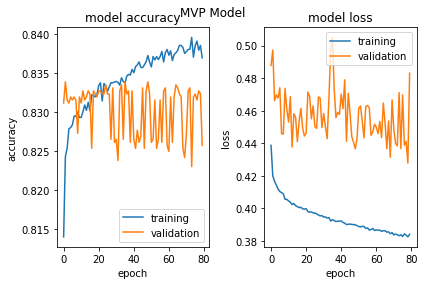

Test loss: 0.421
Test accuracy: 0.824


In [5]:
model = fresh_model()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_df.values, y_train_df.values, batch_size=32, epochs=80, verbose=False, validation_split=.1)
plot_training_history(history, model, 'MVP Model')

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


In [7]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


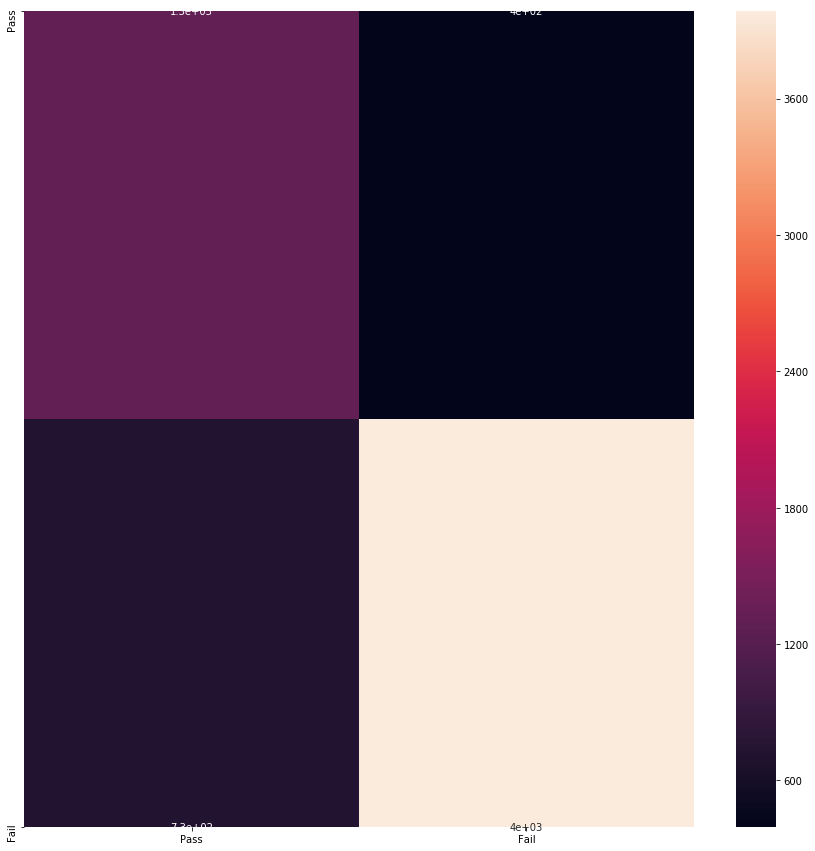

In [8]:
# When did our evaluator do poorly?

name_labels = ["Pass", "Fail"]

predictions = model.predict(x_test_df.values)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(y_test_df.values, axis=1))
plt.figure(figsize = (15, 15))
sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)

Normalized confusion matrix
[[0.63976378 0.36023622]
 [0.09041096 0.90958904]]


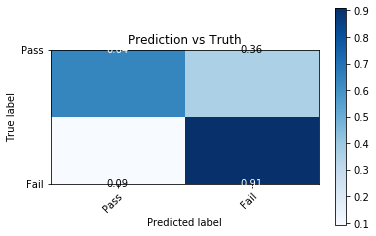

In [9]:
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_df.values, axis=1)
ax = plot_confusion_matrix( y_true, y_pred, np.array(name_labels), title="Prediction vs Truth",normalize=True)
plt.show(ax)

In [64]:
unique_labels(y_true, y_pred)

array([0, 1])

Normalized confusion matrix
[[0.65674603 0.34325397]
 [0.09540151 0.90459849]]


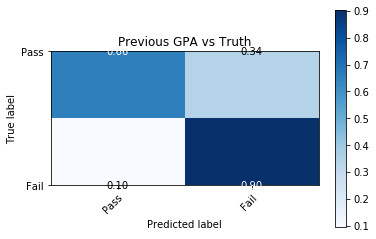

In [65]:
y_pred = np.argmax(predictions, axis=1)
#y_veri = np.argmax(y_verify_df.values, axis=1)
y_true = np.argmax(y_test_df.values, axis=1)
ax = plot_confusion_matrix( y_true, y_pred, np.array(name_labels), title="Previous GPA vs Truth",normalize=True)
plt.show(ax)

The ML model in the coarse estimation case did not do much better than just using the PREV_GPA feature to predict the LAST_GPA value (less than 3% improvement). 

In [66]:
y_pred_df = pd.DataFrame(y_pred)
y_ver_df = pd.DataFrame(y_veri)
corr = y_pred_df.corrwith(y_ver_df)
corr


0    0.84539
dtype: float64